In [2]:
import tensorflow as tf
import numpy as np
import os
import sys

In [3]:
# Path para importacion de funciones
dir_actual    = os.path.abspath('')
dir_parent = os.path.dirname(dir_actual)
if not dir_parent in sys.path: sys.path.append(dir_parent)

## Loading Test Data

In [4]:
# Loading Data
(_, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Normalizando
x_test = x_test/255.
# Adding Channel Lenght Dimension: Expanding from (28x28) to (28x28x1)
x_test = tf.expand_dims(x_test, -1)

## Creating Dataset Objects

In [5]:
from functions import to_categorical

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(to_categorical)
test_dataset = test_dataset.batch(1)

## Loading Quantized model and Non Quantized model 

En base al resultado del ultimo item del cuaderno "Lenet 5 Analysis" las entradas/salidas de las capas tienen valores que varian entre -15.6 y 15.8, aunque los valores maximos y minimos varian enormemente entre capas, por ahora realizaremos una cuantizacion igual para cada capa.

Considerando un bit para el signo, se necesitan al menos 4 bits para la parte entera, se medirá el accuracy de modelos en funcion del numero de bits destinados a la parte fraccionaria.

In [7]:
from models import Lenet_body

input_layer   = tf.keras.Input((28, 28, 1))
output_layer  = Lenet_body(input_layer, Quantization = False)


Frac_Bits = 4
Int_Bits  = 3

Qinput_layer  = tf.keras.Input((28, 28, 1))
Qoutput_layer = Lenet_body(Qinput_layer, Quantization = True, word_size = (Frac_Bits+Int_Bits+1), frac_size = Frac_Bits)

Lenet  = tf.keras.Model(inputs=input_layer, outputs=output_layer)
QLenet = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)

## Loading Pretrained Weights

In [8]:
# Loading Wieghts
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd,'TrainedWeights')
Wgt_dir = os.path.join(Wgt_dir,'Weights')

Lenet.load_weights(Wgt_dir)
QLenet.load_weights(Wgt_dir)

## Quantize Weights

En base al resultado del ultimo item del cuaderno "Lenet 5 Analysis" los pesos valores que varian entre -0.9 y 1.6, en este caso no hay grandes variaciones entre valores por capa.

In [9]:
from models import Weight_Quantization
Weight_Quantization(model = QLenet, Frac_Bits = 8, Int_Bits = 5)

## Check the general Accuracy

In [10]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
Lenet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QLenet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Original Model

In [12]:
Lenet.evaluate(test_dataset)

10000/10000 [==============================] - 34s 3ms/step - loss: 0.3196 - accuracy: 0.8883


[0.3196016080860579, 0.8883]

# Experimento 1: Cuantizacion homogenea, sin saturacion

### 1 bit Precision for Weights && 1 bit Precicion for Activations

In [68]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 32s 3ms/step - loss: 7.6026 - accuracy: 0.4099


[7.602550701546669, 0.4099]

### 2 bit Precision for Weights && 2 bit Precicion for Activations

In [73]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 32s 3ms/step - loss: 1.1185 - accuracy: 0.8493


[1.1184957627177239, 0.8493]

### 3 bit Precision for Weights && 3 bit Precicion for Activations

In [78]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 32s 3ms/step - loss: 0.6949 - accuracy: 0.8729


[0.6948502577155831, 0.8729]

### 4 bit Precision for Weights && 4 bit Precicion for Activations

In [13]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 34s 3ms/step - loss: 0.5429 - accuracy: 0.8827


[0.5428545123860242, 0.8827]

Notice how even with low precicion (2 bits fractionals) the network accuracy is almost unaffected.

# Experimento 2: Variacion de precision en los pesos, precision fija de activaciones (4 bits), sin saturacion

### 3 bits de precision para pesos

In [18]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 34s 3ms/step - loss: 0.5130 - accuracy: 0.8761


[0.5130198137916626, 0.8761]

### 2 bits de precision para pesos

In [23]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 33s 3ms/step - loss: 0.6065 - accuracy: 0.8592


[0.6065071309164168, 0.8592]

# Experimento 3: Variacion de precision en las activaciones, precision fija de pesos (4 bits), sin saturacion

### 3 bits de precision para activaciones

In [28]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 34s 3ms/step - loss: 0.6788 - accuracy: 0.8793


[0.6788031583905222, 0.8793]

### 2 bits de precision para activaciones

In [33]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 33s 3ms/step - loss: 0.9723 - accuracy: 0.8731


[0.9722800113618374, 0.8731]

# Experimento 4: Variacion en el numero de bits para la parte entera de los pesos (precision de 4 bits tanto para pesos como activaciones)

### 1 bit para parte entera pesos

In [38]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 34s 3ms/step - loss: 0.5429 - accuracy: 0.8827


[0.5428545123860242, 0.8827]

### 0 bit para parte entera pesos

In [43]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 34s 3ms/step - loss: 0.5480 - accuracy: 0.8826


[0.5480399408109488, 0.8826]

# Experimento 5: Variacion en el numero de bits para la parte entera de las activaciones (precision de 4 bits tanto para pesos como activaciones)

### 3 bits para parte entera activaciones

In [48]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 34s 3ms/step - loss: 0.5120 - accuracy: 0.8827


[0.5120041680052878, 0.8827]

### 2 bits para parte entera activaciones

In [53]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 34s 3ms/step - loss: 0.8235 - accuracy: 0.6588


[0.8234586628906428, 0.6588]

# Experimento 6: Variacion en la precision de pesos en capas FC (precision de 4 bits para lo demas), sin saturacion

### 3 bits de precision para pesos de capas FC

In [58]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 34s 3ms/step - loss: 0.5104 - accuracy: 0.8791


[0.5103918347626927, 0.8791]

### 2 bits de precision para pesos de capas FC

In [67]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 34s 3ms/step - loss: 0.5751 - accuracy: 0.8678


[0.5750690444841983, 0.8678]

# Resumen de mejores configuraciones

### Pesos capas no FC: precicion = 4, parte entera = 0.  
### Pesos capas FC: precicion = 3, parte entera = 0.
### Activaciones:    precicion = 3, parte entera = 3.

In [73]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 33s 3ms/step - loss: 0.6558 - accuracy: 0.8757


[0.655784740304947, 0.8757]

### Pesos capas no FC: precicion = 4, parte entera = 0.  
### Pesos capas FC: precicion = 4, parte entera = 0.
### Activaciones:    precicion = 4, parte entera = 3.

In [78]:
QLenet.evaluate(test_dataset)

10000/10000 [==============================] - 33s 3ms/step - loss: 0.5225 - accuracy: 0.8826


[0.5225470440737905, 0.8826]

## Comparative Plot

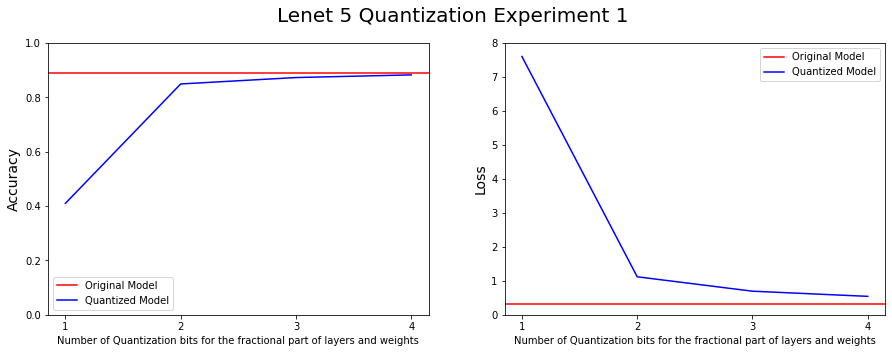

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Lenet 5 Quantization Experiment 1',fontsize=20)

Acc  = [0.4099, 0.8493, 0.8729, 0.8827]
Qbits = [1, 2, 3, 4]

axs[0].set_xticks(Qbits)
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Number of Quantization bits for the fractional part of layers and weights')
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].axhline(y=0.8883, color='r', linestyle='-')
axs[0].plot(Qbits,Acc, color = 'b', linestyle='-')
axs[0].legend(('Original Model','Quantized Model'))

Loss = [7.602550701546669, 1.1184957627177239, 0.6948502577155831, 0.5428545123860242]

axs[1].set_xticks(Qbits)
axs[1].set_ylim([0, 8])
axs[1].set_xlabel('Number of Quantization bits for the fractional part of layers and weights')
axs[1].set_ylabel('Loss',fontsize=14)
axs[1].axhline(y=0.3196016080860579, color='r', linestyle='-')
axs[1].plot(Qbits,Loss, color = 'b', linestyle='-')
axs[1].legend(('Original Model','Quantized Model'))

fig.savefig('Figuras/Experimentos_Cuantizacion/Lenet 5 Quantization Experiment 1.png')

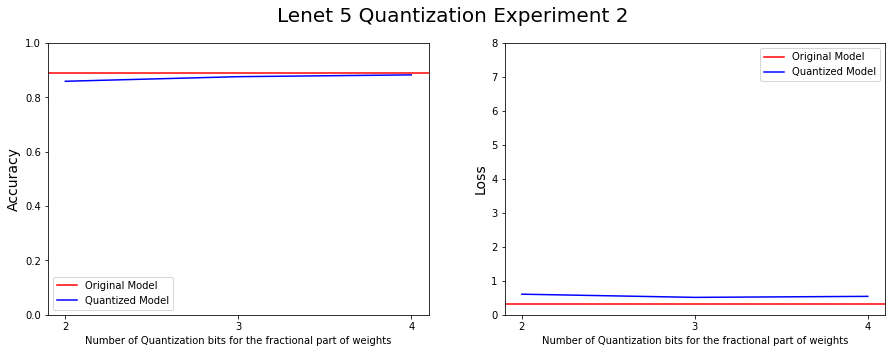

In [13]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Lenet 5 Quantization Experiment 2',fontsize=20)

Acc  = [0.8592, 0.8761, 0.8827]
Qbits = [2, 3, 4]

axs[0].set_xticks(Qbits)
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Number of Quantization bits for the fractional part of weights')
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].axhline(y=0.8883, color='r', linestyle='-')
axs[0].plot(Qbits,Acc, color = 'b', linestyle='-')
axs[0].legend(('Original Model','Quantized Model'))

Loss = [0.6065071309164168, 0.5130198137916626, 0.5428545123860242]

axs[1].set_xticks(Qbits)
axs[1].set_ylim([0, 8])
axs[1].set_xlabel('Number of Quantization bits for the fractional part of weights')
axs[1].set_ylabel('Loss',fontsize=14)
axs[1].axhline(y=0.3196016080860579, color='r', linestyle='-')
axs[1].plot(Qbits,Loss, color = 'b', linestyle='-')
axs[1].legend(('Original Model','Quantized Model'))

fig.savefig('Figuras/Experimentos_Cuantizacion/Lenet 5 Quantization Experiment 2.png')

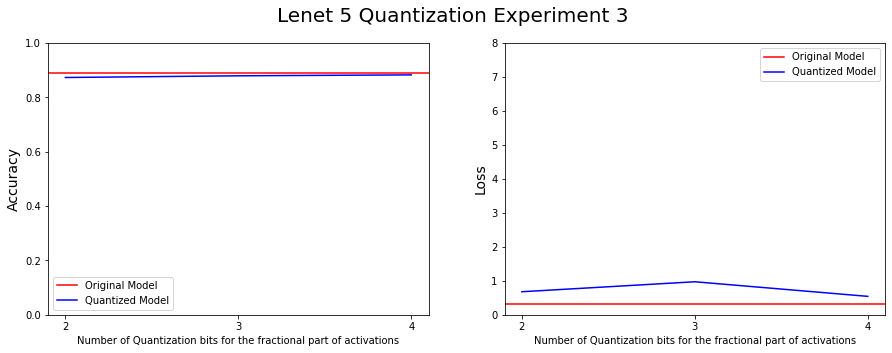

In [14]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Lenet 5 Quantization Experiment 3',fontsize=20)

Acc  = [0.8731, 0.8793, 0.8827]
Qbits = [2, 3, 4]

axs[0].set_xticks(Qbits)
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Number of Quantization bits for the fractional part of activations')
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].axhline(y=0.8883, color='r', linestyle='-')
axs[0].plot(Qbits,Acc, color = 'b', linestyle='-')
axs[0].legend(('Original Model','Quantized Model'))

Loss = [0.6788031583905222, 0.9722800113618374, 0.5428545123860242]

axs[1].set_xticks(Qbits)
axs[1].set_ylim([0, 8])
axs[1].set_xlabel('Number of Quantization bits for the fractional part of activations')
axs[1].set_ylabel('Loss',fontsize=14)
axs[1].axhline(y=0.3196016080860579, color='r', linestyle='-')
axs[1].plot(Qbits,Loss, color = 'b', linestyle='-')
axs[1].legend(('Original Model','Quantized Model'))

fig.savefig('Figuras/Experimentos_Cuantizacion/Lenet 5 Quantization Experiment 3.png')

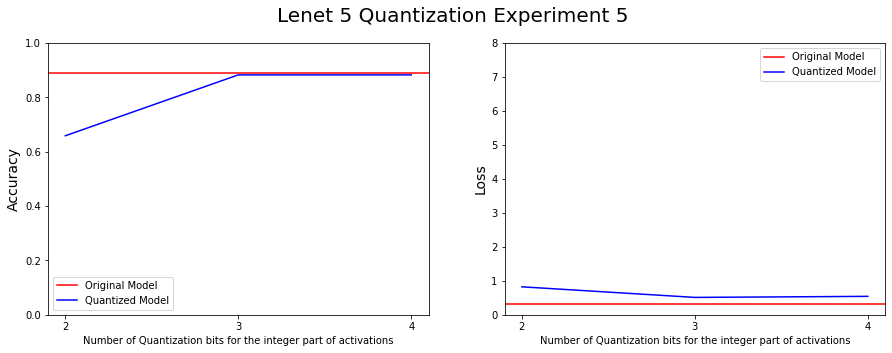

In [15]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Lenet 5 Quantization Experiment 5',fontsize=20)

Acc  = [0.6588, 0.8827, 0.8827]
Qbits = [2, 3, 4]

axs[0].set_xticks(Qbits)
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Number of Quantization bits for the integer part of activations')
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].axhline(y=0.8883, color='r', linestyle='-')
axs[0].plot(Qbits,Acc, color = 'b', linestyle='-')
axs[0].legend(('Original Model','Quantized Model'))

Loss = [0.8234586628906428, 0.5120041680052878, 0.5428545123860242]

axs[1].set_xticks(Qbits)
axs[1].set_ylim([0, 8])
axs[1].set_xlabel('Number of Quantization bits for the integer part of activations')
axs[1].set_ylabel('Loss',fontsize=14)
axs[1].axhline(y=0.3196016080860579, color='r', linestyle='-')
axs[1].plot(Qbits,Loss, color = 'b', linestyle='-')
axs[1].legend(('Original Model','Quantized Model'))

fig.savefig('Figuras/Experimentos_Cuantizacion/Lenet 5 Quantization Experiment 5.png')